In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

# Преобразование Бокса-Кокса

Если случайная величина имеет логнормальное распределение, то ее логарифм имеет нормальное распределение.

In [3]:
data_log = pd.Series(np.random.lognormal(0, 1, 1000))

<Axes: >

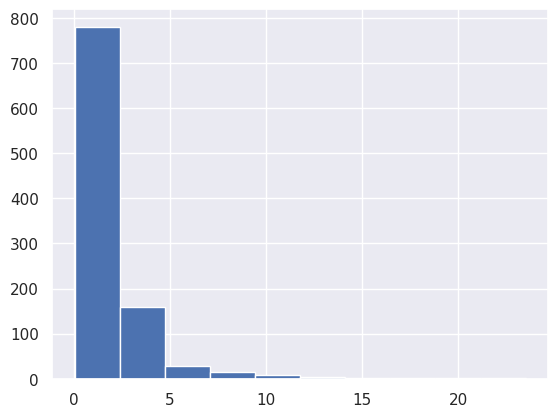

In [4]:
data_log.hist()

<Axes: >

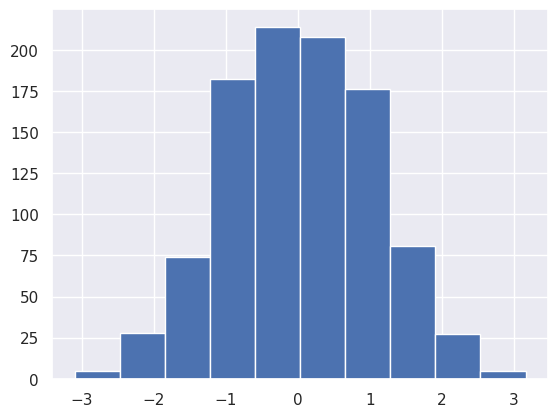

In [5]:
np.log(data_log).hist()

Почему это работает?

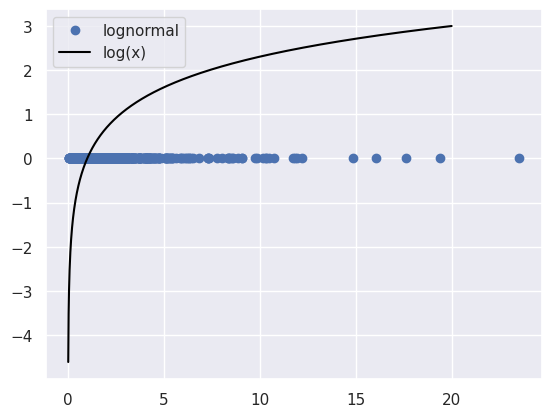

In [6]:
log_x = np.arange(0.01, 20, 0.01)
log_y = np.log(log_x)

x_points = data_log
y_points = np.zeros(1000)

fig = plt.figure()
plt.plot(x_points, y_points, 'o', label="lognormal")
plt.plot(log_x, log_y, 'black', label='log(x)')

plt.legend()

fig.show()

Если экспоненциальное распределение?

In [7]:
data_exp = pd.Series(np.random.exponential(size=1000))

<Axes: >

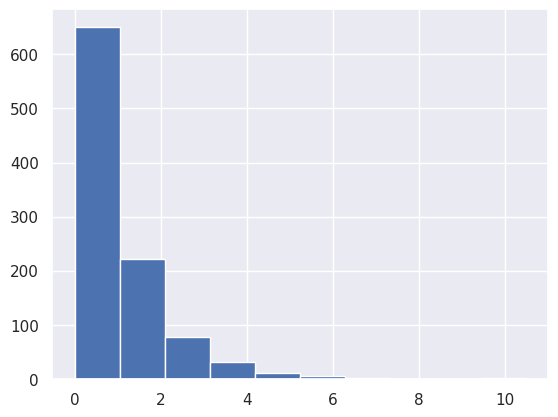

In [8]:
data_exp.hist()

<Axes: >

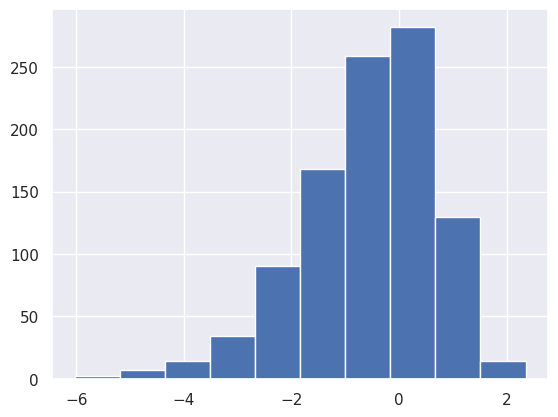

In [9]:
np.log(data_exp).hist()

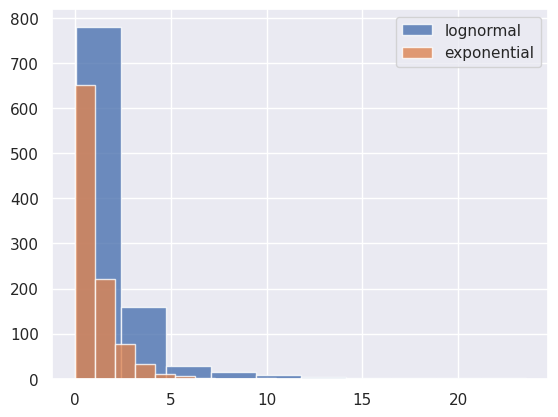

In [10]:
plt.hist(data_log, label='lognormal', alpha=.8)
plt.hist(data_exp, label='exponential', alpha=.8)
plt.legend()

plt.show()

Найдем такое преобразование.

$$\int\frac{1}{x^{1-\lambda}}=\frac{x^\lambda-1}{\lambda}+C,$$
где $\lambda$ - искомый параметр.

$$x^*_i=\begin{cases}
\ln(x), & \lambda=0 \\
\frac{x^\lambda-1}{\lambda}, & \text{в обратном случае.}
\end{cases}$$

In [11]:
from scipy.stats import boxcox
transformed_data, best_lambda = boxcox(data_exp)

<Axes: >

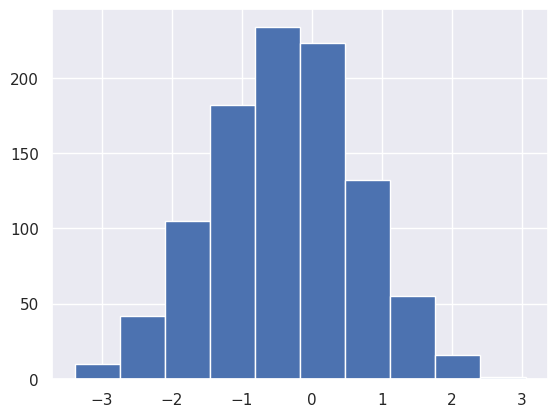

In [12]:
pd.Series(transformed_data).hist()

In [13]:
best_lambda

0.214271552291052

# Отбор признаков

In [14]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]

In [15]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

## Корреляционный анализ

In [16]:
train_X.columns

Index(['back-suspension', 'battery-capacity', 'charge-time', 'compression',
       'consumption-mixed', 'cylinders-order', 'cylinders-value',
       'engine-feeding', 'engine-start', 'engine-stop', 'engine-type',
       'gear-type', 'luxury', 'max-speed', 'power-electro-kw', 'supply-system',
       'valves', 'valvetrain', 'weight', 'configurations_auto-premiere',
       'configurations_back-wheel-base', 'configurations_front-brake',
       'configurations_safety-rating', 'configurations_seats',
       'configurations_tank-volume', 'supergen_year-stop',
       'models_country-from', 'models_group', 'models_light-and-commercial',
       'models_male'],
      dtype='object')

In [17]:
ordinal = ['back-suspension', 'cylinders-order', 'engine-feeding', 'configurations_seats']
numerical = ['battery-capacity', 'charge-time', 'compression', 'consumption-mixed', 'cylinders-value', 'engine-start', 'engine-stop', 'luxury',
             'max-speed', 'power-electro-kw','valves','weight','configurations_auto-premiere','configurations_back-wheel-base','configurations_tank-volume',
             'supergen_year-stop',]
catigorial = ['engine-type','gear-type', 'supply-system', 'valvetrain', 'configurations_front-brake', 'configurations_safety-rating','models_country-from',
              'models_group', 'models_light-and-commercial','models_male']

<Axes: xlabel='engine-type', ylabel='Count'>

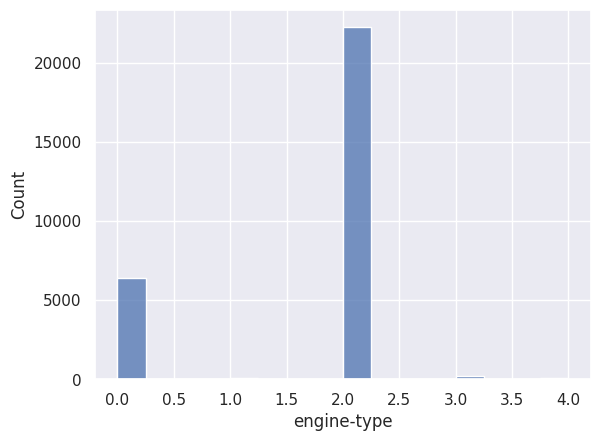

In [18]:
sns.histplot(data=train_X, x='engine-type')

In [19]:
### sns.pairplot(train_X[numerical]);

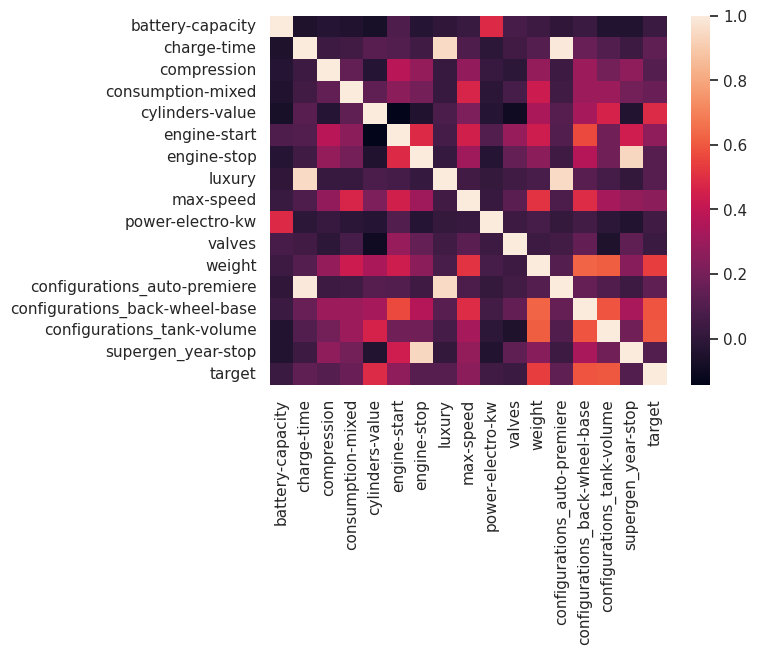

In [20]:
train = train_X
train['target'] = train_y
sns.heatmap(train[numerical + ['target']].corr(method='spearman'));

In [21]:
from scipy.stats import pearsonr, spearmanr
# check if correlation is significant
r = pearsonr(train['configurations_auto-premiere'], train['target'])
print('Pearson correlation:', r[0], 'p-value:', r[1])

Pearson correlation: 0.11003752360955589 p-value: 9.725646829239856e-79


In [22]:
r = pearsonr(train['battery-capacity'], train['target'])
print('Pearson correlation:', r[0], 'p-value:', r[1])
# у нас оч маленькие значения, т.е. отвергаем H0

Pearson correlation: 0.023665183667099614 p-value: 5.610547363610232e-05


## F-test

In [23]:
from sklearn.feature_selection import f_regression, SelectKBest

In [24]:
f_statistic, p_values = f_regression(train_X, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
p_values

array([4.14261514e-178, 5.61054736e-005, 2.22583374e-084, 4.29215233e-006,
       5.19880608e-097, 0.00000000e+000, 0.00000000e+000, 3.00761649e-002,
       1.23407205e-153, 1.91780781e-122, 1.08128701e-102, 5.89170255e-038,
       1.18423856e-051, 6.73034264e-090, 6.04804785e-008, 3.29025321e-015,
       3.33873440e-033, 1.45689423e-002, 0.00000000e+000, 9.72564683e-079,
       6.46321123e-022, 5.15233301e-231, 8.63015515e-002, 0.00000000e+000,
       0.00000000e+000, 1.90641086e-122, 7.01981268e-140, 5.09638729e-005,
       4.56879391e-064, 3.51507643e-001, 1.00000000e+000])

In [26]:
sekector = SelectKBest(f_regression, k=20)
sekector.fit_transform(train_X, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 3.0000e+00,  1.1636e+04, -1.0000e+00, ...,  2.0000e+03,
         1.6000e+01,  0.0000e+00],
       [ 8.0000e+00,  3.1764e+04, -1.0000e+00, ...,  1.9960e+03,
         2.3000e+01,  0.0000e+00],
       [ 8.0000e+00,  2.7730e+03,  6.8000e+00, ...,  2.0120e+03,
         1.0000e+01,  0.0000e+00],
       ...,
       [ 3.0000e+00,  4.8819e+04,  7.6000e+00, ..., -1.0000e+00,
         2.6000e+01,  0.0000e+00],
       [ 1.0000e+01,  9.3460e+03, -1.0000e+00, ...,  1.9950e+03,
         1.6000e+01,  0.0000e+00],
       [ 3.0000e+00,  4.3309e+04, -1.0000e+00, ...,  2.0070e+03,
         3.5000e+01,  0.0000e+00]])

In [27]:
sekector.get_feature_names_out()

array(['back-suspension', 'charge-time', 'consumption-mixed',
       'cylinders-order', 'cylinders-value', 'engine-start',
       'engine-stop', 'engine-type', 'gear-type', 'luxury', 'max-speed',
       'valves', 'weight', 'configurations_auto-premiere',
       'configurations_front-brake', 'configurations_seats',
       'configurations_tank-volume', 'supergen_year-stop',
       'models_country-from', 'models_light-and-commercial'], dtype=object)

## Значения Шепли

In [28]:
pip install shap

In [29]:
import shap

In [30]:
reg = LinearRegression().fit(train_X, train_y)

In [31]:
explainer = shap.Explainer(reg, train_X)
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X)

ValueError: operands could not be broadcast together with shapes (1,30) (31,) 

Для признака cylinders-value наблюдается положительная статистическая зависимость от целевой переменной. Сравните Ваш результат с результатом работы библиотеки shap.

In [32]:
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]

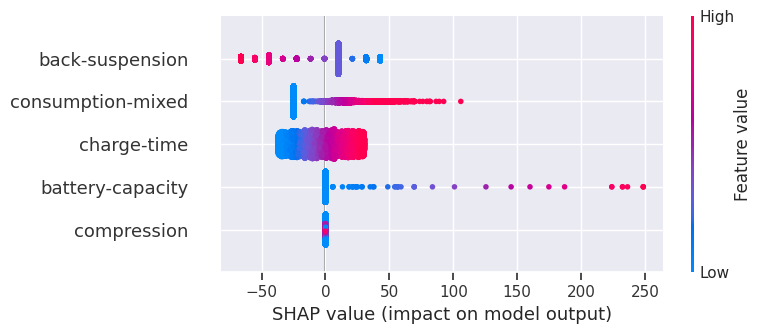

In [33]:
reg = LinearRegression().fit(train_cut_X, train_y)

explainer = shap.Explainer(reg, train_cut_X)
shap_values = explainer(test_cut_X)

shap.summary_plot(shap_values, test_cut_X)

### Задание

Для сокращенных данных (train_cut_X и test_cut_X) реализовать метод отбора важности признаков по Шепли.

In [34]:
import math
from sklearn.metrics import r2_score
from itertools import chain, combinations

def powerset(iterable): # спасибо стаку за сабсеты
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [35]:
selected = []
for col in train_cut_X.columns:
    s = list(powerset(train_cut_X.columns))
    k = 0
    for _ in s:
        n = (math.factorial(len(s))*math.factorial((len(train_cut_X.columns)+len(s))))/math.factorial(len(train_cut_X.columns))
        model = LinearRegression().fit(train_cut_X, train_y)
        predictions = model.predict(test_cut_X)
        R2 = r2_score(test_y, predictions)

        train_cut_X_drop = train_cut_X.drop(col, axis=1)
        test_cut_X_drop = test_cut_X.drop(col, axis=1)
        reg1 = LinearRegression().fit(train_cut_X_drop, train_y)
        predictions1 = reg1.predict(test_cut_X_drop)

        R_2 = r2_score(test_y, predictions1)
        k += n*(R2**2-R_2**2)
    selected.append(k)
print(selected)

[7.844275671031067e+74, 9.284687109637701e+73, 3.6868035391765984e+74, 3.377456271499781e+71, 5.216844990633395e+74]


In [36]:
len(train_cut_X.columns)

5

## Пермутационная важность

In [37]:
pip install eli5

In [38]:
import eli5
from eli5.sklearn import PermutationImportance

In [39]:
df = pd.read_csv('https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv', sep=',')
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [40]:
reg = LinearRegression().fit(train_X, train_y)

In [41]:
perm = PermutationImportance(reg, random_state=42).fit(test_X, test_y)

In [42]:
eli5.show_weights(perm, feature_names=list(test_X.columns))

Weight,Feature
0.3617 ± 0.0044,cylinders-value
0.1035 ± 0.0039,configurations_tank-volume
0.0959 ± 0.0066,configurations_seats
0.0498 ± 0.0020,engine-type
0.0466 ± 0.0009,engine-start
0.0291 ± 0.0012,configurations_auto-premiere
0.0287 ± 0.0023,charge-time
0.0196 ± 0.0027,compression
0.0193 ± 0.0019,gear-type
0.0165 ± 0.0020,weight


### Задание

Самостоятельно реализовать алгоритм отбора признаков на основе пермутационной важности. Построить гистограмму полученных значений.

In [43]:
import random

In [44]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [45]:
# для начала обучим модель и посмотрим изнач лосс со всеми признаками
model = LinearRegression().fit(train_X, train_y)
predictions = model.predict(test_X)
MSE = mean_squared_error(test_y, predictions)
print(MSE)

31015.75310911929


[('cylinders-value', 34782.69286849841, 1.1214524679161042),
 ('configurations_seats', 33412.21849226995, 1.0772660710420103),
 ('configurations_tank-volume', 32805.17518709246, 1.0576939747900898),
 ('engine-type', 31840.73804855694, 1.0265989007758476),
 ('engine-start', 31575.095294055387, 1.018034131977006),
 ('gear-type', 31404.67351159485, 1.0125394473288223)]
None


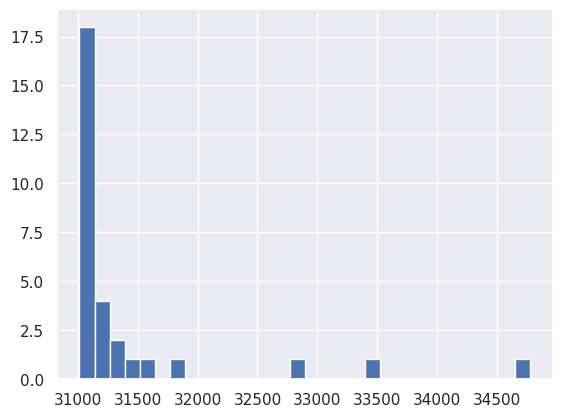

In [46]:
import pprint
def feat_selection(X):
  mses, fis = [], [] # fis будет содерж. feature importance
  for i in X.columns:
    X1 = X.copy() # т.к. кажд. раз возвращаем изнач. датасет
    lst = X1[i].to_list()
    random.shuffle(lst)
    X1[i] = lst
    # теперь чекаем результат с перемеш. признаком
    train_X, test_X, train_y, test_y = train_test_split(X1, y, test_size=0.33, random_state=42)
    reg = LinearRegression().fit(train_X, train_y)
    predictions = reg.predict(test_X)

    mse = mean_squared_error(test_y, predictions)
    mses.append(mse)
    fi = mse / MSE # можно вычесть общий мсе из конкретного
    fis.append(fi)

  #print()
  pprint.pprint(sorted(tuple(zip(X.columns, mses, fis)), key=lambda x:x[2], reverse=True)[:6])
  plt.hist(mses, len(X.columns));


print(feat_selection(X))

# Домашнее задание

Сгенерировать полиномиальные признаки для рассматриваегомого сегодня набора данных. Попробовать отобрать признаки различными методами (можно теми, что не рассматривали). Получить максимальное качество на тестовых данных. Проинтерпретировать результаты.

In [47]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]

In [48]:
# изначальные показ-ли качества модели
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)


In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # приведем к единому масштабу
train_X_st = scaler.fit_transform(train_X)
test_X_st = scaler.transform(test_X)

In [50]:
model = LinearRegression()
model.fit(train_X_st, train_y)
predictions = model.predict(test_X_st)

In [51]:
from sklearn.metrics import  mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

print('RMSE : ', np.sqrt(mean_squared_error(test_y,predictions)))
print('R2 Score : ', r2_score(test_y,predictions))
print('MSE : ', mean_squared_error(test_y,predictions))

RMSE :  176.11289875849343
R2 Score :  0.4647153732232171
MSE :  31015.75310911936


In [53]:
# теперь с полином. признаками
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)

poly_cols = poly.get_feature_names_out(X.columns)
polys = pd.DataFrame(poly_features, columns=poly_cols)

X_new = pd.concat([X, polys], axis=1)
X_new

,back-suspension,battery-capacity,charge-time,compression,consumption-mixed,cylinders-order,cylinders-value,engine-feeding,engine-start,engine-stop,...,models_country-from^2,models_country-from models_group,models_country-from models_light-and-commercial,models_country-from models_male,models_group^2,models_group models_light-and-commercial,models_group models_male,models_light-and-commercial^2,models_light-and-commercial models_male,models_male^2
0,9,-1.0,36457,9.0,4.3,0,3,4,2006,2018,...,256.0,48.0,0.0,16.0,9.0,0.0,3.0,0.0,0.0,1.0
1,3,-1.0,44872,8.0,-1.0,3,7,4,1982,1993,...,1156.0,102.0,0.0,34.0,9.0,0.0,3.0,0.0,0.0,1.0
2,3,-1.0,55927,16.0,4.2,0,4,5,2014,2018,...,1225.0,105.0,0.0,35.0,9.0,0.0,3.0,0.0,0.0,1.0
3,0,-1.0,41405,10.3,-1.0,0,4,4,2000,2003,...,100.0,30.0,0.0,10.0,9.0,0.0,3.0,0.0,0.0,1.0
4,8,-1.0,22523,19.0,-1.0,0,4,8,2000,2005,...,100.0,30.0,0.0,10.0,9.0,0.0,3.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43240,9,-1.0,34558,11.2,6.6,0,4,4,2004,2016,...,225.0,45.0,0.0,15.0,9.0,0.0,3.0,0.0,0.0,1.0
43241,3,-1.0,38268,9.6,5.8,0,4,2,2013,2015,...,100.0,30.0,0.0,10.0,9.0,0.0,3.0,0.0,0.0,1.0
43242,3,-1.0,8958,10.0,9.3,0,4,4,1991,1999,...,256.0,48.0,0.0,16.0,9.0,0.0,3.0,0.0,0.0,1.0
43243,3,-1.0,20293,8.5,-1.0,0,5,4,2002,2004,...,784.0,84.0,0.0,28.0,9.0,0.0,3.0,0.0,0.0,1.0


In [54]:
 train_X, test_X, train_y, test_y = train_test_split(X_new, y, test_size=0.33, random_state=42)


In [56]:
sekector = SelectKBest(f_regression, k=20)
sekector.fit_transform(train_X, train_y) #отберем наилучшие

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[4.000e+00, 5.000e+01, 4.000e+00, ..., 6.500e+02, 2.500e+03,
        1.500e+02],
       [4.000e+00, 4.800e+01, 4.000e+00, ..., 6.240e+02, 2.304e+03,
        1.440e+02],
       [4.000e+00, 5.600e+01, 4.000e+00, ..., 7.280e+02, 3.136e+03,
        1.680e+02],
       ...,
       [4.000e+00, 6.200e+01, 4.000e+00, ..., 8.060e+02, 3.844e+03,
        1.860e+02],
       [4.000e+00, 5.000e+01, 4.000e+00, ..., 6.500e+02, 2.500e+03,
        1.500e+02],
       [7.000e+00, 6.600e+01, 7.000e+00, ..., 5.280e+02, 4.356e+03,
        1.980e+02]])

In [57]:

sekector.get_feature_names_out()

array(['cylinders-value', 'configurations_tank-volume', 'cylinders-value',
       'configurations_tank-volume', 'cylinders-order cylinders-value',
       'cylinders-order configurations_seats',
       'cylinders-order configurations_tank-volume', 'cylinders-value^2',
       'cylinders-value engine-start', 'cylinders-value weight',
       'cylinders-value configurations_seats',
       'cylinders-value configurations_tank-volume',
       'cylinders-value models_group',
       'engine-start configurations_tank-volume', 'weight^2',
       'weight configurations_seats', 'weight configurations_tank-volume',
       'configurations_seats configurations_tank-volume',
       'configurations_tank-volume^2',
       'configurations_tank-volume models_group'], dtype=object)

In [58]:
# по Шепли
selected = []
for col in sekector.get_feature_names_out():
    s = list(powerset(sekector.get_feature_names_out()))
    k = 0
    for _ in s:
        n = (math.factorial(len(s))*math.factorial((len(sekector.get_feature_names_out())+len(s))))/math.factorial(len(sekector.get_feature_names_out()))
        model = LinearRegression().fit(train_X, train_y)
        predictions = model.predict(test_X)
        R2 = r2_score(test_y, predictions)

        train_cut_X_drop = train_X.drop(col, axis=1)
        test_cut_X_drop = test_X.drop(col, axis=1)
        reg1 = LinearRegression().fit(train_cut_X_drop, train_y)
        predictions1 = reg1.predict(test_cut_X_drop)

        R_2 = r2_score(test_y, predictions1)
        k += n*(R2**2-R_2**2)
    selected.append(k)
print(selected)

OverflowError: integer division result too large for a float

In [60]:
reg = LinearRegression().fit(train_X, train_y)

explainer = shap.Explainer(reg, train_X)
shap_values = explainer(test_X)

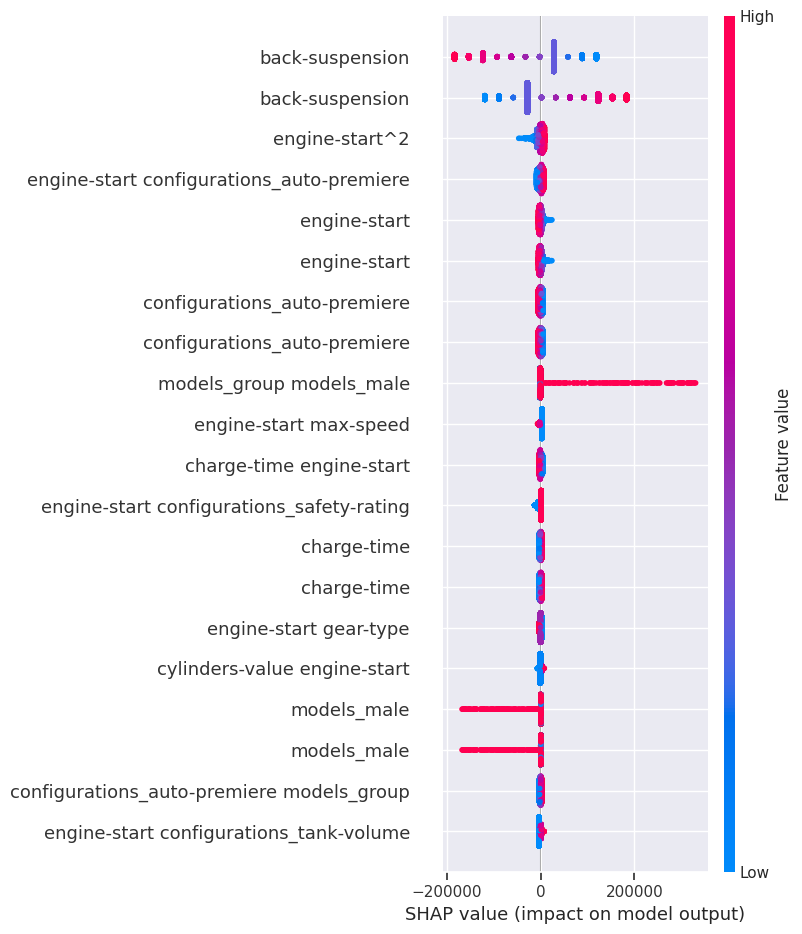

In [61]:

shap.summary_plot(shap_values, test_X)

In [63]:
reg = LinearRegression().fit(train_X, train_y)
perm = PermutationImportance(reg, random_state=42).fit(test_X, test_y)
eli5.show_weights(perm, feature_names=list(test_X.columns))

Weight,Feature
271041.2603 ± 2735.4815,back-suspension
271024.1485 ± 3309.4127,back-suspension
13130.2888 ± 210.7624,models_group models_male
3386.8722 ± 13.6802,models_male
3379.1533 ± 27.6307,models_male
1497.9126 ± 26.9127,engine-start^2
702.7905 ± 15.2009,engine-start configurations_auto-premiere
386.7007 ± 4.8298,engine-start
386.4984 ± 4.6922,engine-start
301.6916 ± 5.0162,configurations_auto-premiere


[('cylinders-value', 34782.2154882512, 1.1214370763747306),
 ('configurations_seats', 33411.9457089722, 1.0772572760500978),
 ('configurations_tank-volume', 32814.92647702758, 1.0580083727639453),
 ('engine-type', 31839.854007180547, 1.026570397796304),
 ('engine-start', 31571.338013098277, 1.0179129909251061),
 ('gear-type', 31406.224999098857, 1.0125894698931157)]
None


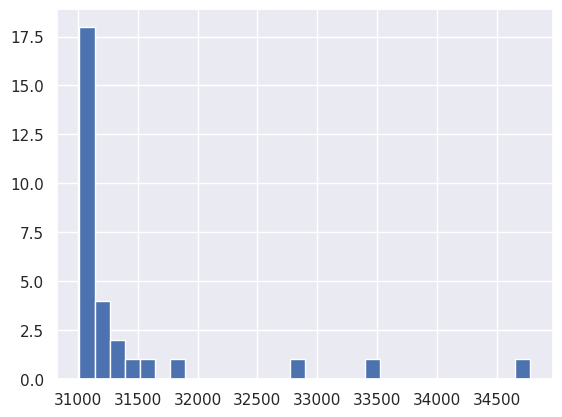

In [64]:
def feat_selection(X):
  mses, fis = [], [] # fis будет содерж. feature importance
  for i in X.columns:
    X1 = X.copy() # т.к. кажд. раз возвращаем изнач. датасет
    lst = X1[i].to_list()
    random.shuffle(lst)
    X1[i] = lst
    # теперь чекаем результат с перемеш. признаком
    train_X, test_X, train_y, test_y = train_test_split(X1, y, test_size=0.33, random_state=42)
    reg = LinearRegression().fit(train_X, train_y)
    predictions = reg.predict(test_X)

    mse = mean_squared_error(test_y, predictions)
    mses.append(mse)
    fi = mse / MSE # можно вычесть общий мсе из конкретного
    fis.append(fi)

  #print()
  pprint.pprint(sorted(tuple(zip(X.columns, mses, fis)), key=lambda x:x[2], reverse=True)[:6])
  plt.hist(mses, len(X.columns));


print(feat_selection(X))